In [1]:
import torch, os 
import torchvision
import numpy 
import torch.nn as nn
import torch.optim as optim
import tqdm
from focal_loss.focal_loss import FocalLoss

In [2]:
from torch.autograd import Variable 

In [3]:
from torch.utils.data import DataLoader,Dataset
from torchvision.models import densenet121
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [4]:
import numpy as np

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ])
}

data_dir = 'tiny-imagenet-200/'
num_workers = {
    'train' : 100,
    'val'   : 0,
    'test'  : 0
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=num_workers[x])
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [6]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity,self).__init__()

  def forward(self,x):
    return x

In [7]:
class FocalLoss1():
    def _focal(y_true, y_pred):
        """ Compute the focal loss given the target tensor and the predicted tensor.
        As defined in https://arxiv.org/abs/1708.02002
        Args
            y_true: Tensor of target data from the generator with shape (B, N, num_classes).
            y_pred: Tensor of predicted data from the network with shape (B, N, num_classes).
        Returns
            The focal loss of y_pred w.r.t. y_true.
        """
        labels         = y_true[:, :, :-1]
        anchor_state   = y_true[:, :, -1]  # -1 for ignore, 0 for background, 1 for object
        classification = y_pred

        # filter out "ignore" anchors
        indices        = backend.where(keras.backend.not_equal(anchor_state, -1))
        labels         = backend.gather_nd(labels, indices)
        classification = backend.gather_nd(classification, indices)

        # compute the focal loss
        alpha_factor = keras.backend.ones_like(labels) * alpha
        alpha_factor = backend.where(keras.backend.equal(labels, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = backend.where(keras.backend.equal(labels, 1), 1 - classification, classification)
        focal_weight = backend.clip(focal_weight, backend.epsilon(), 1.0) # avoid NaN when net output is 1.0 or 0.0
        focal_weight = alpha_factor * focal_weight ** gamma

        cls_loss = focal_weight * keras.backend.binary_crossentropy(labels, classification)

        # compute the normalizer: the number of positive anchors
        normalizer = backend.where(keras.backend.equal(anchor_state, 1))
        normalizer = keras.backend.cast(keras.backend.shape(normalizer)[0], keras.backend.floatx())
        normalizer = keras.backend.maximum(keras.backend.cast_to_floatx(1.0), normalizer)

        return keras.backend.sum(cls_loss) / normalizer

In [8]:
model_ft = densenet121(pretrained=True)
model_ft.fc = Identity()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

#Loss Function
criterion = FocalLoss(alpha=2, gamma=10)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [9]:
import torch, time, copy, sys, os
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

def train_model(output_path, model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=5, scheduler=None):
    if not os.path.exists('models/'+str(output_path)):
        os.makedirs('models/'+str(output_path))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler != None:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print(inputs.size())
                #print(labels.size())
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    
                    #labels.view(1,1000)
                    #print(outputs.size())
                    #print(labels.size())
                    #break
                    _, preds = torch.max(outputs, 1)
                    labels = labels.view(100, 1)
                    #loss = criterion._focal(outputs,labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)), end="")

#                 print( (i+1)*100. / len(dataloaders[phase]), "% Complete" )
                sys.stdout.flush()
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                avg_loss = epoch_loss
                t_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc
            
#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best = epoch + 1
                best_model_wts = copy.deepcopy(model.state_dict())
                
        liveloss.update({
            'log loss': avg_loss,
            'val_log loss': val_loss,
            'accuracy': t_acc,
            'val_accuracy': val_acc
        })
                
        liveloss.draw()
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, t_acc))
        print(  'Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print()
        torch.save(model.state_dict(), './models/' + str(output_path) + '/model_{}_epoch.pt'.format(epoch+1))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {}, Epoch: {}'.format(best_acc, best))

Using TensorFlow backend.


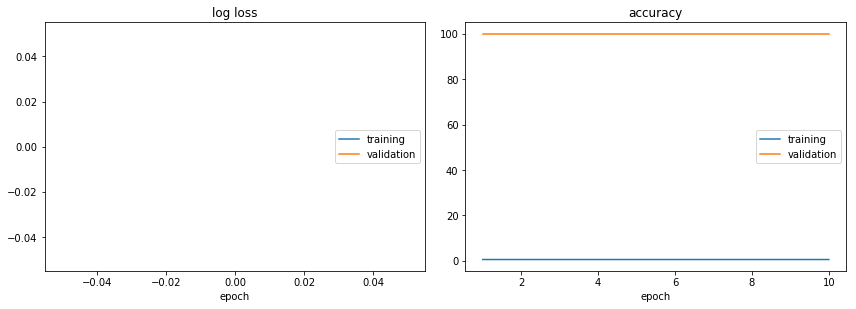

Train Loss: nan Acc: 0.5000
Val Loss: nan Acc: 100.0000

Training complete in 23m 56s
Best Validation Accuracy: 100.0, Epoch: 1


In [10]:
#Train
train_model("DenseNet",model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, num_epochs=10)

In [13]:
import torch, time, sys

def test_model(model, dataloaders, dataset_sizes, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()

    # Each epoch has a training and validation phase
    for phase in ['test']:
        model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i,(inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.view(100,1))

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)), end="")
            sys.stdout.flush()


        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
    print()
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print()
    
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [14]:
#Test
test_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft)

Iteration: 100/100, Loss: nan.
Test Loss: nan Acc: 1.0000

Test complete in 0m 8s
